# Dog and Cat Classification using DeepLearning

- Implementing a deep learning pipeline for classifying images of cats and dogs using the PyTorch framework. It begins by preparing a dataset, visualizing class distributions, and splitting data into training and testing sets. Image preprocessing involves resizing, random transformations, and normalization.

- The model architecture utilizes a pretrained ResNet-18 with the final layer adapted for binary classification (cats vs. dogs). Training involves defining a loss function (CrossEntropyLoss), an optimizer (Adam), and a learning rate scheduler. The training loop iterates through epochs, evaluating performance with training loss plotted over epochs.

- After training, the model is evaluated on a test set to compute accuracy, achieving approximately 90.27% accuracy in this case. Trained model parameters are saved for future use. Inference capabilities include loading a single image, preprocessing it for prediction, and using the model to classify it as a cat or dog, with visualization of the prediction.

- The code's modularity, utilizing PyTorch's DataLoader for efficient batch processing and GPU acceleration if available. Visualization tools such as matplotlib and seaborn aid in understanding dataset characteristics and model performance. Overall, it provides a robust framework for training and deploying a deep learning model for binary image classification tasks.

# Contributors

- S.Dinesh Kumar
- Y.Gokul

### Panimalar Engineering College Chennai

# References:

- https://www.geeksforgeeks.org/cat-dog-classification-using-convolutional-neural-network-in-python/
- https://pytorch.org/vision/stable/index.html
- http://pytorch.org/vision/stable/models.html
    
    
# Support:
- Mr.Kanav Bansal Cheif DataScientist (Innomatics Research Labs)

# Importing the Torch and Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision

In [2]:
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\svani\kagglecatsanddogs


##  Creating a class for Custom Dataset
- This CustomDataset class is a custom dataset wrapper compatible with PyTorch's Dataset class. It takes images and labels, optionally applies transformations to the images, and allows for easy access to individual samples by index. This setup is useful for training machine learning models using PyTorch, where datasets need to be loaded and preprocessed efficiently.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


## Creating a function to load Images
- This function load_images takes a list of image file paths, attempts to load each image using OpenCV, converts the color space from BGR to RGB, converts the numpy array to a PIL Image object, and collects all successfully loaded images into a list. Images that fail to load are logged as warnings. This function is useful for preprocessing image data before using it in tasks like training machine learning models using frameworks such as PyTorch.

In [4]:

def load_images(image_paths):
    images = []
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            images.append(img)
        else:
            print(f"Warning: Unable to read image {img_path}")
    return images


## Creating the Data Frame for Images and Labels

In [5]:
def create_image_dataframe(base_dir):
    data = []
    for label, subdir in [("Cat", os.path.join(base_dir, "Cat")), ("Dog", os.path.join(base_dir, "Dog"))]:
        for image_path in glob(os.path.join(subdir, "*.jpg")):
            data.append({"image_path": image_path, "label": label})
    df = pd.DataFrame(data)
    return df

In [6]:
# Target Directory

In [7]:
base_dir = os.path.join(r"C:\Users\svani\kagglecatsanddogs\PetImages\Sample\Dataset")
data = create_image_dataframe(base_dir)

In [8]:
data.head()


,image_path,label
0,C:\Users\svani\kagglecatsanddogs\PetImages\Sam...,Cat
1,C:\Users\svani\kagglecatsanddogs\PetImages\Sam...,Cat
2,C:\Users\svani\kagglecatsanddogs\PetImages\Sam...,Cat
3,C:\Users\svani\kagglecatsanddogs\PetImages\Sam...,Cat
4,C:\Users\svani\kagglecatsanddogs\PetImages\Sam...,Cat


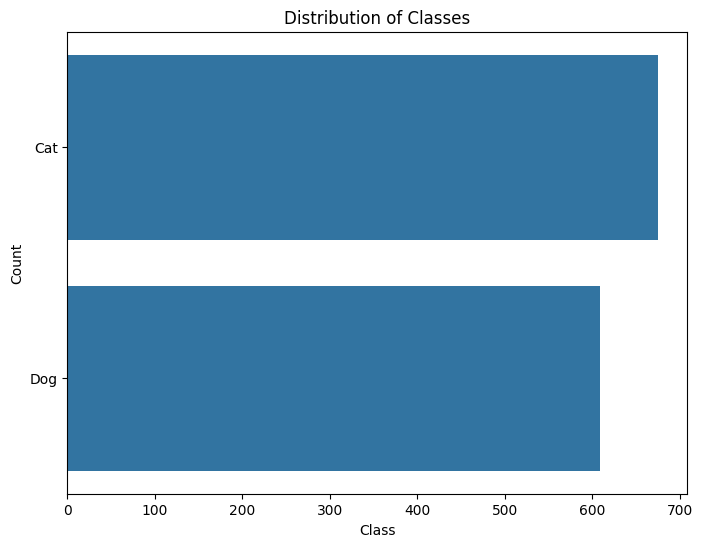

In [9]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
sns.countplot(data['label'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [10]:
# Exploring the Sample Images of Cat & Dog

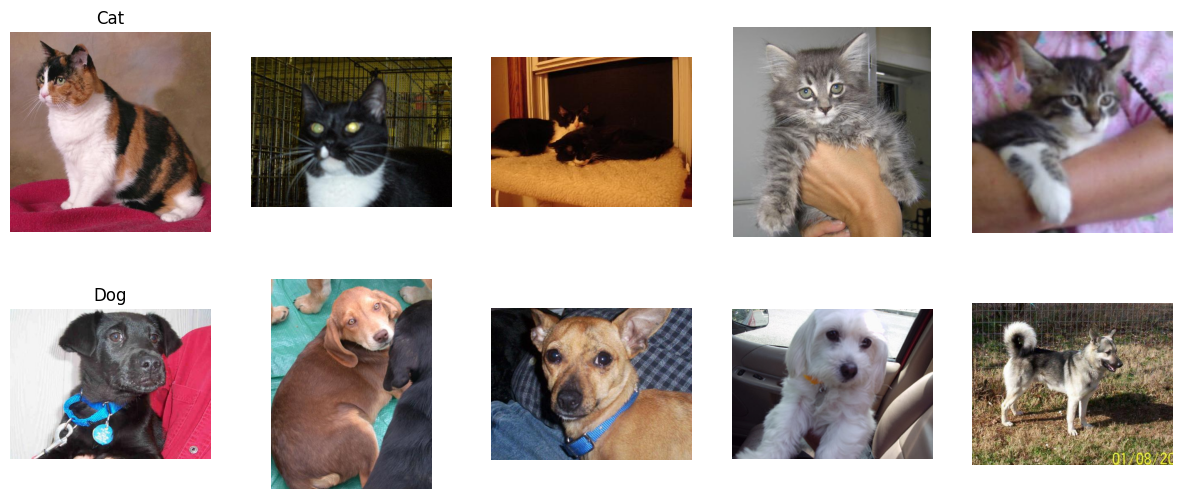

In [11]:
def show_examples(df, num_examples=5):
    fig, axs = plt.subplots(2, num_examples, figsize=(15, 6))
    classes = df['label'].unique()
    for i, label in enumerate(classes):
        examples = df[df['label'] == label].sample(num_examples)
        for j, image_path in enumerate(examples['image_path']):
            img = Image.open(image_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(label)
    plt.show()

show_examples(data)

In [12]:
data['label'].value_counts()

label
Cat    675
Dog    609
Name: count, dtype: int64

In [13]:
# Splitting the Data by utilizing the Sklearn Library

In [14]:
X = data['image_path']  
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.map({'Cat': 0, 'Dog': 1}).values
y_test = y_test.map({'Cat': 0, 'Dog': 1}).values

In [15]:
# Applying Transformation Filter for the splitted Data

In [16]:

train_images = load_images(X_train)
test_images = load_images(X_test)

transform = transforms.Compose([
    transforms.Resize((128, 128)),# Resizing the images
    transforms.RandomHorizontalFlip(),
    # Stabilizing the Images
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),# Enhancing the Images
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normaliation
])


100%|███████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 286.03it/s]


In [17]:
# Function to load and transform an image
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image)
    return transformed_image

In [18]:
# Plotting the Transformed images
def plot_images(original_image, transformed_image):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = transformed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
    transformed_image = transformed_image.clip(0, 1)
    axs[1].imshow(transformed_image)
    axs[1].set_title('Transformed Image')
    axs[1].axis('off')
    plt.show()


In [19]:
# Sample of transformed Images

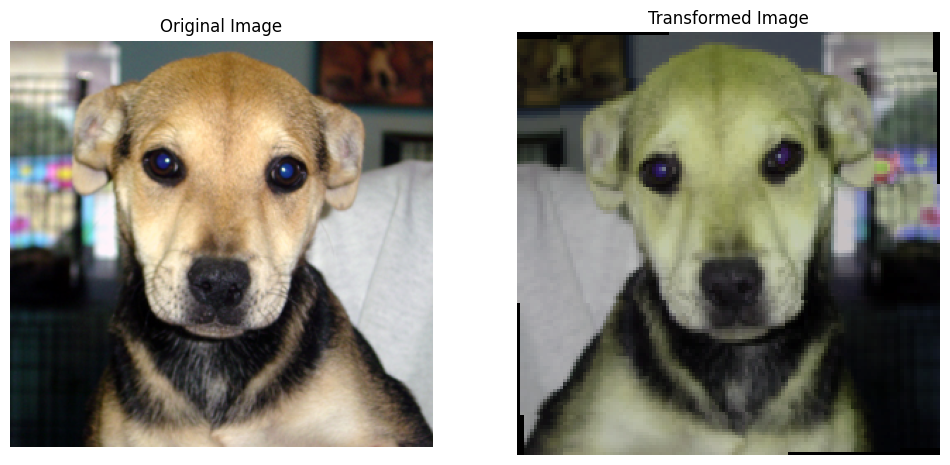

In [20]:
sample_image_path = r"C:\Users\svani\kagglecatsanddogs\PetImages\Sample\Dataset\Dog\4.jpg"
original_image = Image.open(sample_image_path).convert('RGB')
transformed_image = load_and_transform_image(sample_image_path, transform)
plot_images(original_image, transformed_image)

In [21]:
# Training Data Preparation

In [22]:
train_dataset = CustomDataset(train_images, y_train, transform=transform)
test_dataset = CustomDataset(test_images, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
# Transformed and Enhanced Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


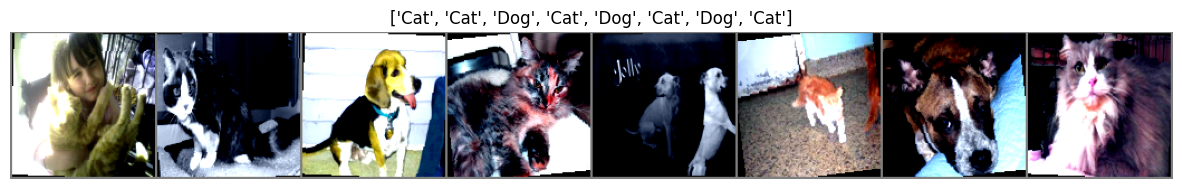

In [24]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

def plot_batch_of_images(dataloader, classes, num_images=8):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    out = torchvision.utils.make_grid(images[:num_images], nrow=num_images)
    plt.figure(figsize=(15, 15))
    imshow(out, title=[classes[labels[j]] for j in range(num_images)])
    plt.show()

classes = ['Cat', 'Dog']
plot_batch_of_images(train_loader, classes)


In [25]:
# Torch's loading pretrained Architecture and Utilizing for Traning the Data

In [26]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

C:\Users\svani\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\svani\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Optimazation of the Training Process 

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
# Training Loop Started

In [30]:
n_epochs = 15
epoch_losses = []
for epoch in tqdm(range(n_epochs), desc='Epochs'):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}', leave=False):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    tqdm.write(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epochs:   7%|█████                                                                      | 1/15 [00:54<12:37, 54.12s/it]

Epoch 1, Loss: 0.6145



Epochs:  13%|██████████                                                                 | 2/15 [01:48<11:43, 54.14s/it]

Epoch 2, Loss: 0.4010



Epochs:  20%|███████████████                                                            | 3/15 [02:42<10:47, 53.96s/it]

Epoch 3, Loss: 0.2861



Epochs:  27%|████████████████████                                                       | 4/15 [03:36<09:53, 54.00s/it]

Epoch 4, Loss: 0.2341



Epochs:  33%|█████████████████████████                                                  | 5/15 [04:30<08:59, 53.98s/it]

Epoch 5, Loss: 0.1773



Epochs:  40%|██████████████████████████████                                             | 6/15 [05:24<08:05, 53.98s/it]

Epoch 6, Loss: 0.3424



Epochs:  47%|███████████████████████████████████                                        | 7/15 [06:17<07:10, 53.87s/it]

Epoch 7, Loss: 0.2772



Epochs:  53%|████████████████████████████████████████                                   | 8/15 [07:11<06:16, 53.84s/it]

Epoch 8, Loss: 0.1385



Epochs:  60%|█████████████████████████████████████████████                              | 9/15 [08:05<05:23, 53.86s/it]

Epoch 9, Loss: 0.2071



Epochs:  67%|█████████████████████████████████████████████████▎                        | 10/15 [08:59<04:29, 53.85s/it]

Epoch 10, Loss: 0.1012



Epochs:  73%|██████████████████████████████████████████████████████▎                   | 11/15 [09:52<03:35, 53.81s/it]

Epoch 11, Loss: 0.1197



Epochs:  80%|███████████████████████████████████████████████████████████▏              | 12/15 [10:46<02:41, 53.83s/it]

Epoch 12, Loss: 0.1571



Epochs:  87%|████████████████████████████████████████████████████████████████▏         | 13/15 [11:40<01:47, 53.78s/it]

Epoch 13, Loss: 0.0711



Epochs:  93%|█████████████████████████████████████████████████████████████████████     | 14/15 [12:33<00:53, 53.58s/it]

Epoch 14, Loss: 0.0474



Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [13:27<00:00, 53.83s/it]

Epoch 15, Loss: 0.0539


In [31]:
# Vizuals for Evaluation Metrics

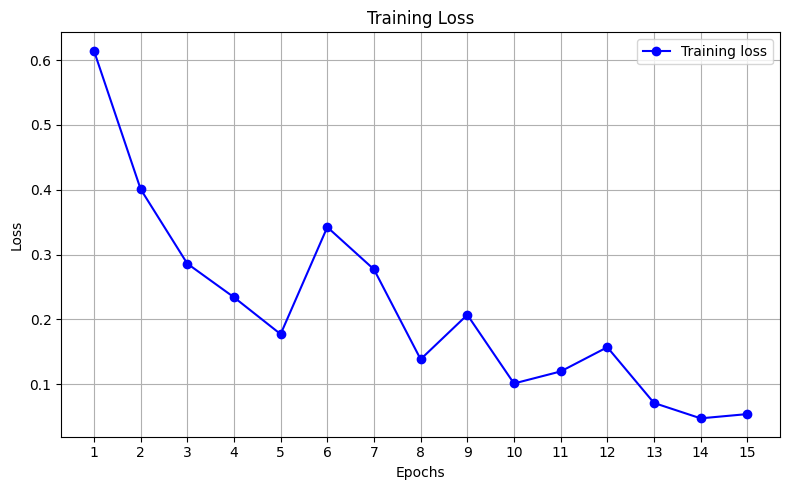

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, n_epochs + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

 - From the Above Graph ,The x-axis is labeled “Epochs” and the y-axis is labeled “Training Loss”. The y-axis starts at 0.02 and goes up to 0.14. The x-axis starts at 1 and goes up to 15. There is a general downward trend in the line graph, which suggests that the training loss is decreasing over time. This means that the 

In [32]:
# Save the trained model
torch.save(model.state_dict(), 'cat_dog_classifier.pth')


In [33]:
# Serialization of the Trained model

In [34]:
model.load_state_dict(torch.load('cat_dog_classifier.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Calculating the Accuracy based on the no of Correct Predicitons by the model from the Testing data

In [52]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        temp, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 91.05%


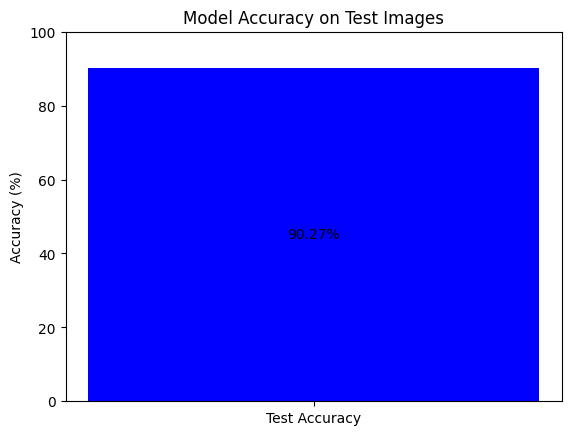

In [37]:
def plot_test_accuracy(accuracy):
    fig, ax = plt.subplots()
    ax.bar(['Test Accuracy'], [accuracy], color='blue')
    ax.set_ylim([0, 100])
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Accuracy on Test Images')
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f%%', label_type='center')
    plt.show()

# Call the plot function
plot_test_accuracy(accuracy)


In [38]:
# Evaluating with New Data

In [39]:
import matplotlib.pyplot as plt

The predicted class for the image is: Dog


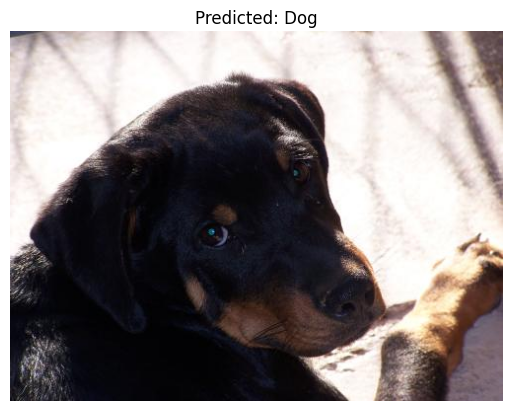

In [50]:
# Define the transformation to match the training data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def predict_image(model, image_path):
    image = load_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return "Cat" if predicted.item() == 0 else "Dog"

def plot_image(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted: {prediction}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = r"C:\Users\svani\kagglecatsanddogs\PetImages\Sample\Dataset\Dog\15.jpg"
prediction = predict_image(model, image_path)
print(f'The predicted class for the image is: {prediction}')
plot_image(image_path, prediction)

# END 